# Feature Importance

In [1]:
# import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load the data
df = pd.read_csv('outputs/train_cleaned_trimmed.csv')

# Review the shape of the data
print(df.shape)

(1399, 73)


In [3]:
# # Remove the outliers from the data using the IQR method
# # Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = df['SalePrice'].quantile(0.25)
# Q3 = df['SalePrice'].quantile(0.75)

# # Compute the Interquartile Range (IQR)
# IQR = Q3 - Q1

# # Define the lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out the outliers
# df = df[(df['SalePrice'] >= lower_bound) & (df['SalePrice'] <= upper_bound)]


## Full Dataset

In [4]:
# Remove the 'Neighborhood' column
df = df.drop(columns=['Neighborhood'], errors='ignore')

# Identify categorical columns (excluding 'SalePrice')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Separate categorical and continuous data
categorical_data = df[categorical_cols]
continuous_data = df.drop(columns=categorical_cols, errors='ignore')

# Function to encode categorical columns
def encode_columns(df, cols_to_encode):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Avoids errors from unseen categories
    df_encoded = df.copy()
    
    for col in cols_to_encode:
        Xd = ohe.fit_transform(df_encoded[[col]])  # One-hot encode the column
        unique_values = ohe.categories_[0]  # Get unique category names
        new_cols = [f"{col}_{val}" for val in unique_values]  # Create new column names
        
        # Create a new DataFrame for encoded columns
        df_ohe = pd.DataFrame(Xd, columns=new_cols, index=df_encoded.index)
        
        # Concatenate with the original DataFrame
        df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

    # Drop original categorical columns
    df_encoded.drop(cols_to_encode, axis=1, inplace=True)
    
    return df_encoded

# Encode the categorical dataset
df_encoded = encode_columns(categorical_data, categorical_cols)

# Merge encoded categorical data with continuous data
df_final = pd.concat([continuous_data, df_encoded], axis=1)

# Display the first 5 rows of the final dataset
df_final.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Neighborhood_Price_Bucket_Level_1,Neighborhood_Price_Bucket_Level_2,Neighborhood_Price_Bucket_Level_3,Neighborhood_Price_Bucket_Level_4
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### CART 

Fitting 3 folds for each of 15 candidates, totalling 45 fits


Test R^2 Score: 0.6734


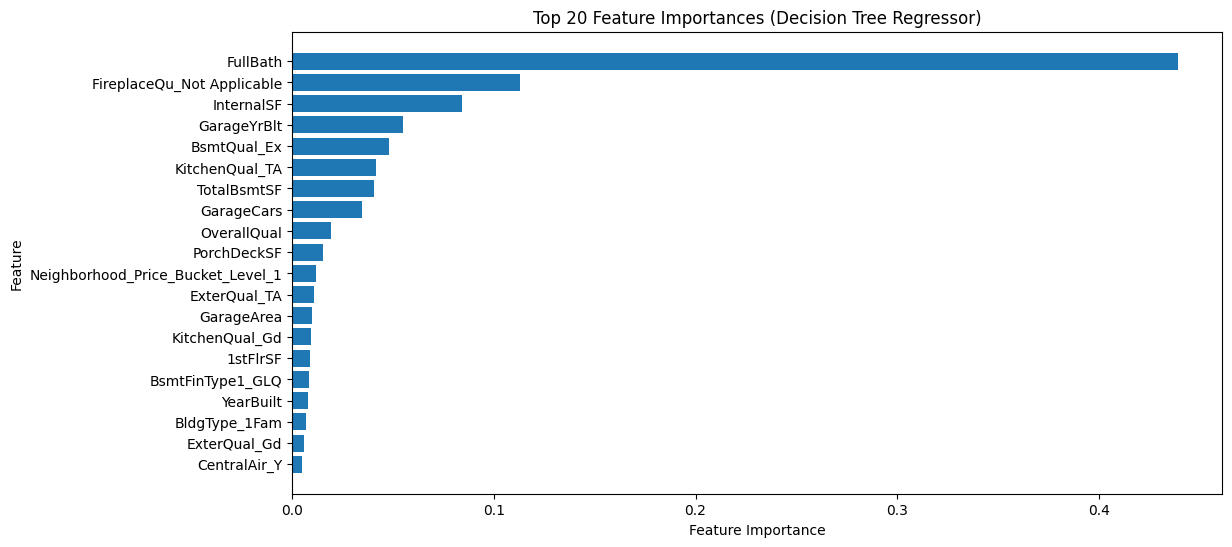

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline  
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform  # Randomized distributions

# Define features and target
columns_to_include = df_final.columns.difference(['SalePrice'])
X = df_final[columns_to_include]
y = df_final['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and the DecisionTreeRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeRegressor(random_state=42))  
])

# Randomized hyperparameter search space
param_dist = {
    'classifier__max_depth': randint(4, 15),  # Prevent overfitting
    'classifier__min_samples_split': randint(5, 20),
    'classifier__min_samples_leaf': randint(2, 10),  # More stable trees
    'classifier__max_features': ['sqrt', 'log2'],  # Use subset of features
    'classifier__criterion': ['squared_error', 'absolute_error'],
    'classifier__min_impurity_decrease': uniform(0.0001, 0.001)  # Forces more meaningful splits
}


# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=15,  # Fewer iterations for speed
    cv=3, scoring='neg_mean_absolute_error', 
    n_jobs=-1, random_state=42, verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model evaluation on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute R^2 and MAE for evaluation
test_r2 = best_model.score(X_test, y_test)
# test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test R^2 Score: {test_r2:.4f}')

# Extract feature importances
dt_model = best_model.named_steps['classifier']
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [columns_to_include[j] for j in indices]

# Select **Top 20** most important features
top_n = 20
top_features = names[:top_n]
top_importances = importances[indices][:top_n]

# Plot Top 20 Feature Importances
plt.figure(figsize=(12, 6))
plt.barh(top_features, top_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Decision Tree Regressor)')
plt.gca().invert_yaxis()
plt.show()


### XGB Boost

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Test R^2 Score: 0.8932


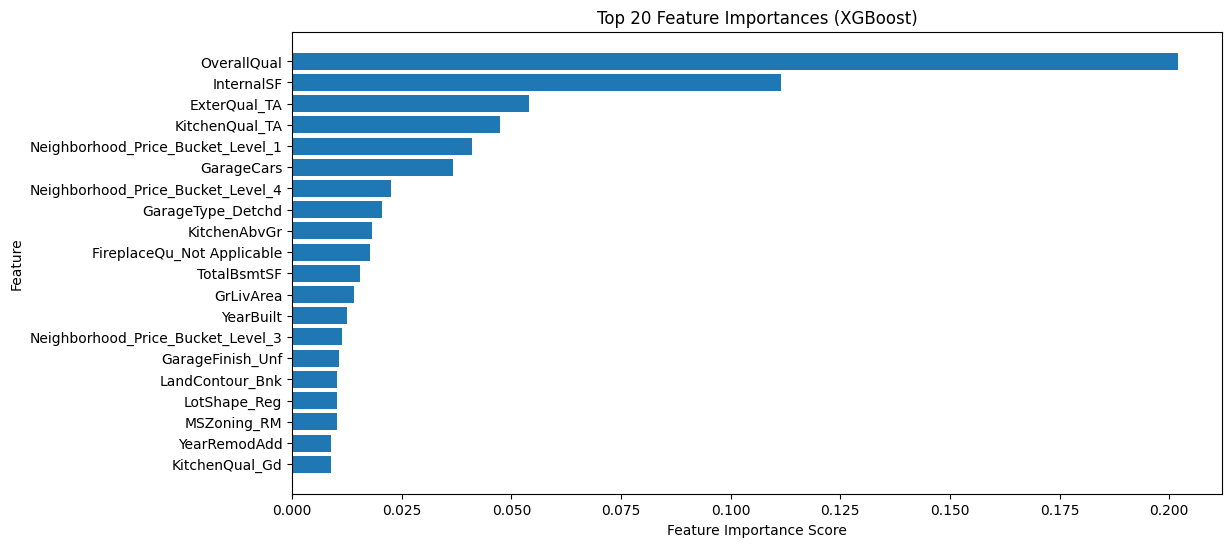

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# Define features and target
columns_to_include = df_final.columns.difference(['SalePrice'])
X = df_final[columns_to_include]
y = df_final['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and XGBoost Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', 
                                    random_state=42, n_jobs=-1))
])

# RandomizedSearch with fewer parameter combinations
param_dist = {
    'classifier__max_depth': randint(4, 12),  
    'classifier__learning_rate': uniform(0.01, 0.1),  
    'classifier__n_estimators': randint(50, 200),  
    'classifier__subsample': uniform(0.7, 0.3),  
    'classifier__colsample_bytree': uniform(0.7, 0.3),  
    'classifier__reg_lambda': uniform(0.1, 10),  
    'classifier__reg_alpha': uniform(0, 1)
}

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=25, cv=3, scoring='r2', n_jobs=-1, verbose=1, random_state=42
)  

# Fit with early stopping
random_search.fit(X_train, y_train)

# Best model evaluation on test set
best_model = random_search.best_estimator_
test_r2 = best_model.score(X_test, y_test)
print(f'Test R^2 Score: {test_r2:.4f}')

# Feature importance extraction
xgb_model = best_model.named_steps['classifier']
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [columns_to_include[j] for j in indices]

# Select **Top 20** most important features
top_n = 20
top_features = names[:top_n]
top_importances = importances[indices][:top_n]

# Plot top 20 feature importances
plt.figure(figsize=(12, 6))
plt.barh(names[:20], importances[indices][:20])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()



In [7]:
print(top_features)

['OverallQual', 'InternalSF', 'ExterQual_TA', 'KitchenQual_TA', 'Neighborhood_Price_Bucket_Level_1', 'GarageCars', 'Neighborhood_Price_Bucket_Level_4', 'GarageType_Detchd', 'KitchenAbvGr', 'FireplaceQu_Not Applicable', 'TotalBsmtSF', 'GrLivArea', 'YearBuilt', 'Neighborhood_Price_Bucket_Level_3', 'GarageFinish_Unf', 'LandContour_Bnk', 'LotShape_Reg', 'MSZoning_RM', 'YearRemodAdd', 'KitchenQual_Gd']


## Continuous Data

In [8]:
# Create a dataframe for the continuous variables
continuous_data = df.select_dtypes(include='number')

# drop the Id column
continuous_data.drop('Id', axis=1, inplace=True)

# Display the first 5 rows of the continuous data
continuous_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice,InternalSF,PorchDeckSF
0,60,65.0,8450,7,5,2003,2003,196.0,706,150,...,61,0,0,0,0,2,2008,208500,2566,61
1,20,80.0,9600,6,8,1976,1976,0.0,978,284,...,0,0,0,0,0,5,2007,181500,2524,298
2,60,68.0,11250,7,5,2001,2002,162.0,486,434,...,42,0,0,0,0,9,2008,223500,2706,42
3,70,60.0,9550,7,5,1915,1970,0.0,216,540,...,35,272,0,0,0,2,2006,140000,2473,307
4,60,84.0,14260,8,5,2000,2000,350.0,655,490,...,84,0,0,0,0,12,2008,250000,3343,276


#### CART

Fitting 3 folds for each of 15 candidates, totalling 45 fits


Test R^2 Score: 0.7390


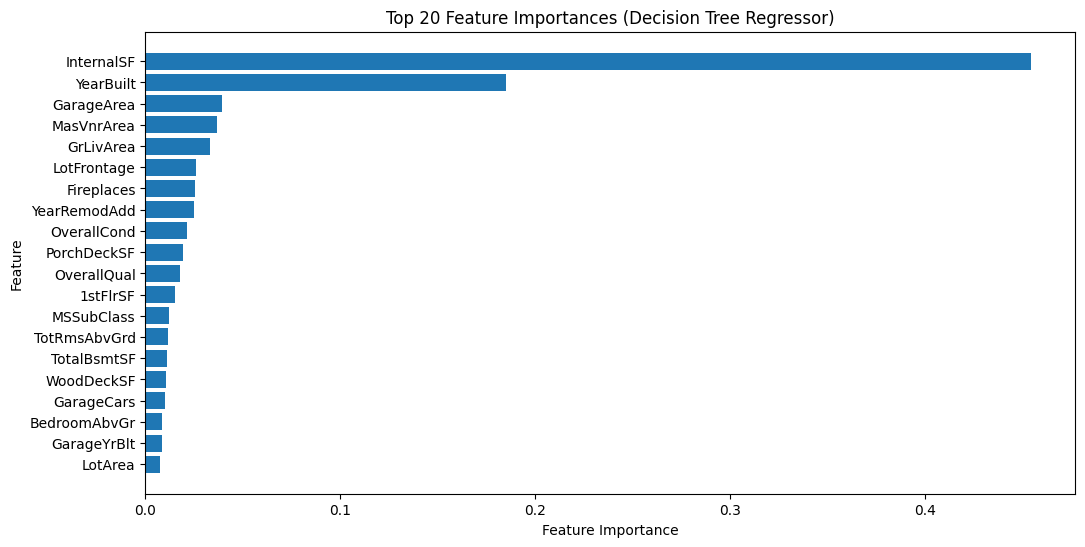

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline  
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform  # Randomized distributions

# Define features and target
columns_to_include = continuous_data.columns.difference(['SalePrice'])
X = continuous_data[columns_to_include]
y = continuous_data['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and the DecisionTreeRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeRegressor(random_state=42))  
])

# Randomized hyperparameter search space
param_dist = {
    'classifier__max_depth': randint(4, 15),  # Prevent overfitting
    'classifier__min_samples_split': randint(5, 20),
    'classifier__min_samples_leaf': randint(2, 10),  # More stable trees
    'classifier__max_features': ['sqrt', 'log2'],  # Use subset of features
    'classifier__criterion': ['squared_error', 'absolute_error'],
    'classifier__min_impurity_decrease': uniform(0.0001, 0.001)  # Forces more meaningful splits
}


# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=15,  # Fewer iterations for speed
    cv=3, scoring='neg_mean_absolute_error', 
    n_jobs=-1, random_state=42, verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model evaluation on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute R^2 and MAE for evaluation
test_r2 = best_model.score(X_test, y_test)
# test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test R^2 Score: {test_r2:.4f}')

# Extract feature importances
dt_model = best_model.named_steps['classifier']
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [columns_to_include[j] for j in indices]

# Select **Top 20** most important features
top_n = 20
top_features = names[:top_n]
top_importances = importances[indices][:top_n]

# Plot Top 20 Feature Importances
plt.figure(figsize=(12, 6))
plt.barh(top_features, top_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Decision Tree Regressor)')
plt.gca().invert_yaxis()
plt.show()



#### XGB Boost

Fitting 3 folds for each of 25 candidates, totalling 75 fits


Test R^2 Score: 0.8701


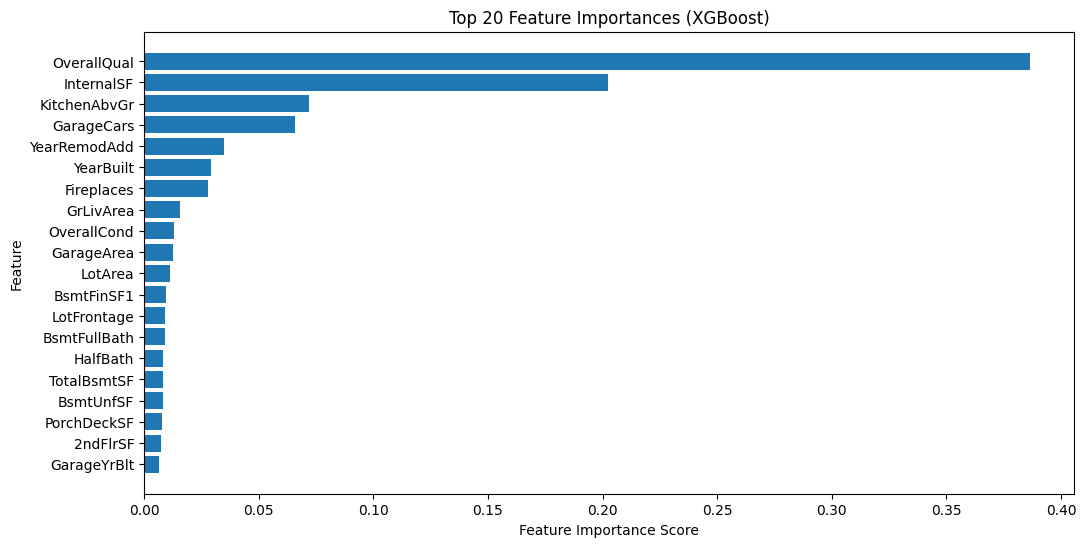

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# Define features and target
columns_to_include = continuous_data.columns.difference(['SalePrice'])
X = continuous_data[columns_to_include]
y = continuous_data['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and XGBoost Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', 
                                    random_state=42, n_jobs=-1))
])

# RandomizedSearch with fewer parameter combinations
param_dist = {
    'classifier__max_depth': randint(4, 12),  
    'classifier__learning_rate': uniform(0.01, 0.1),  
    'classifier__n_estimators': randint(50, 200),  
    'classifier__subsample': uniform(0.7, 0.3),  
    'classifier__colsample_bytree': uniform(0.7, 0.3),  
    'classifier__reg_lambda': uniform(0.1, 10),  
    'classifier__reg_alpha': uniform(0, 1)
}

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=25, cv=3, scoring='r2', n_jobs=-1, verbose=1, random_state=42
)  

# Fit with early stopping
random_search.fit(X_train, y_train)

# Best model evaluation on test set
best_model = random_search.best_estimator_
test_r2 = best_model.score(X_test, y_test)
print(f'Test R^2 Score: {test_r2:.4f}')

# Feature importance extraction
xgb_model = best_model.named_steps['classifier']
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [columns_to_include[j] for j in indices]

# Select **Top 20** most important features
top_n = 20
top_features = names[:top_n]
top_importances = importances[indices][:top_n]

# Plot top 20 feature importances
plt.figure(figsize=(12, 6))
plt.barh(names[:20], importances[indices][:20])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


In [11]:
print(top_features)

['OverallQual', 'InternalSF', 'KitchenAbvGr', 'GarageCars', 'YearRemodAdd', 'YearBuilt', 'Fireplaces', 'GrLivArea', 'OverallCond', 'GarageArea', 'LotArea', 'BsmtFinSF1', 'LotFrontage', 'BsmtFullBath', 'HalfBath', 'TotalBsmtSF', 'BsmtUnfSF', 'PorchDeckSF', '2ndFlrSF', 'GarageYrBlt']


## Categorical Data

In [12]:
# Get categorical columns to encode (excluding 'SalePrice')
cols_to_encode = df.select_dtypes(include=['object'])

def encode_columns(df, cols_to_encode):
    ohe = OneHotEncoder(sparse_output=False)  # Fix: Use sparse_output=False
    df_encoded = df.copy()
    
    for col in cols_to_encode:
        Xd = ohe.fit_transform(df_encoded[[col]])  # One-hot encode the column
        unique_values = ohe.categories_[0]  # Get unique category names
        new_cols = [f"{col}_{val}" for val in unique_values]  # Create new column names
        
        # Create a new DataFrame for encoded columns
        df_ohe = pd.DataFrame(Xd, columns=new_cols, index=df_encoded.index)
        
        # Concatenate with the original DataFrame
        df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

    # Drop original categorical columns
    df_encoded.drop(cols_to_encode, axis=1, inplace=True)
    
    return df_encoded

# Encode the categorical dataset
df_encoded = encode_columns(categorical_data, cols_to_encode)

# Merge the categorical and continuous data to show the 'SalePrice' column
df_encoded = pd.concat([df_encoded, df['SalePrice']], axis=1)

# Display the first 5 rows of the encoded dataset
df_encoded.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Neighborhood_Price_Bucket_Level_1,Neighborhood_Price_Bucket_Level_2,Neighborhood_Price_Bucket_Level_3,Neighborhood_Price_Bucket_Level_4,SalePrice
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,208500
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,181500
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,223500
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,140000
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,250000


### CART

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Test R^2 Score: 0.4597


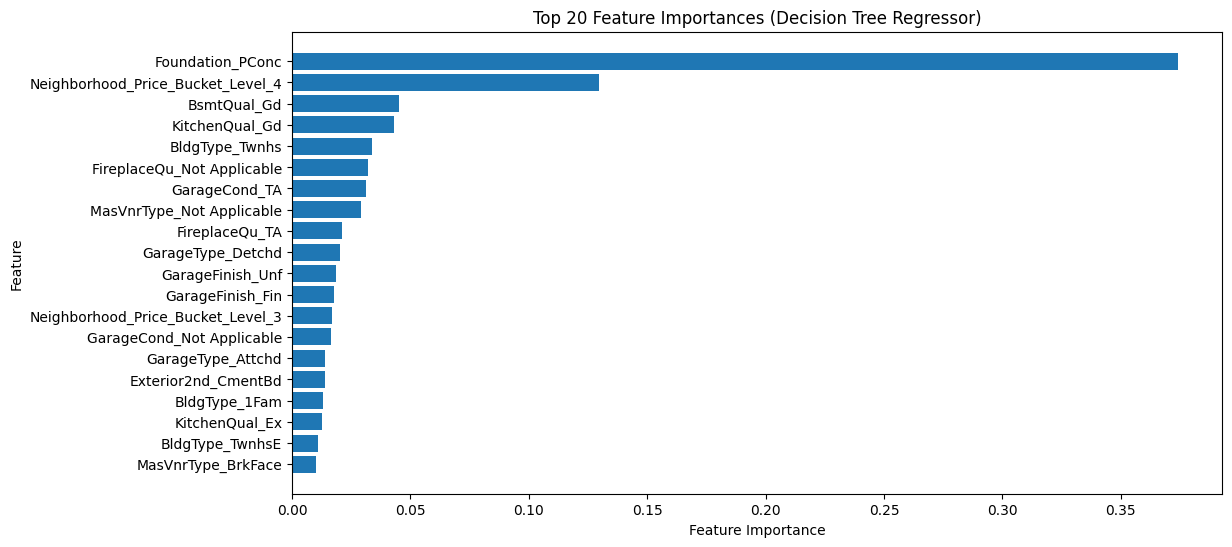

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline  
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform  # Randomized distributions

# Define features and target
columns_to_include = df_encoded.columns.difference(['SalePrice'])
X = df_encoded[columns_to_include]
y = df_encoded['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and the DecisionTreeRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeRegressor(random_state=42))  
])

# Randomized hyperparameter search space
param_dist = {
    'classifier__max_depth': randint(4, 15),  # Prevent overfitting
    'classifier__min_samples_split': randint(5, 20),
    'classifier__min_samples_leaf': randint(2, 10),  # More stable trees
    'classifier__max_features': ['sqrt', 'log2'],  # Use subset of features
    'classifier__criterion': ['squared_error', 'absolute_error'],
    'classifier__min_impurity_decrease': uniform(0.0001, 0.001)  # Forces more meaningful splits
}


# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=15,  # Fewer iterations for speed
    cv=3, scoring='neg_mean_absolute_error', 
    n_jobs=-1, random_state=42, verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model evaluation on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute R^2 and MAE for evaluation
test_r2 = best_model.score(X_test, y_test)
# test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test R^2 Score: {test_r2:.4f}')

# Extract feature importances
dt_model = best_model.named_steps['classifier']
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [columns_to_include[j] for j in indices]

# Select **Top 20** most important features
top_n = 20
top_features = names[:top_n]
top_importances = importances[indices][:top_n]

# Plot Top 20 Feature Importances
plt.figure(figsize=(12, 6))
plt.barh(top_features, top_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Decision Tree Regressor)')
plt.gca().invert_yaxis()
plt.show()


#### XG Boost

Fitting 3 folds for each of 25 candidates, totalling 75 fits


Test R^2 Score: 0.7763


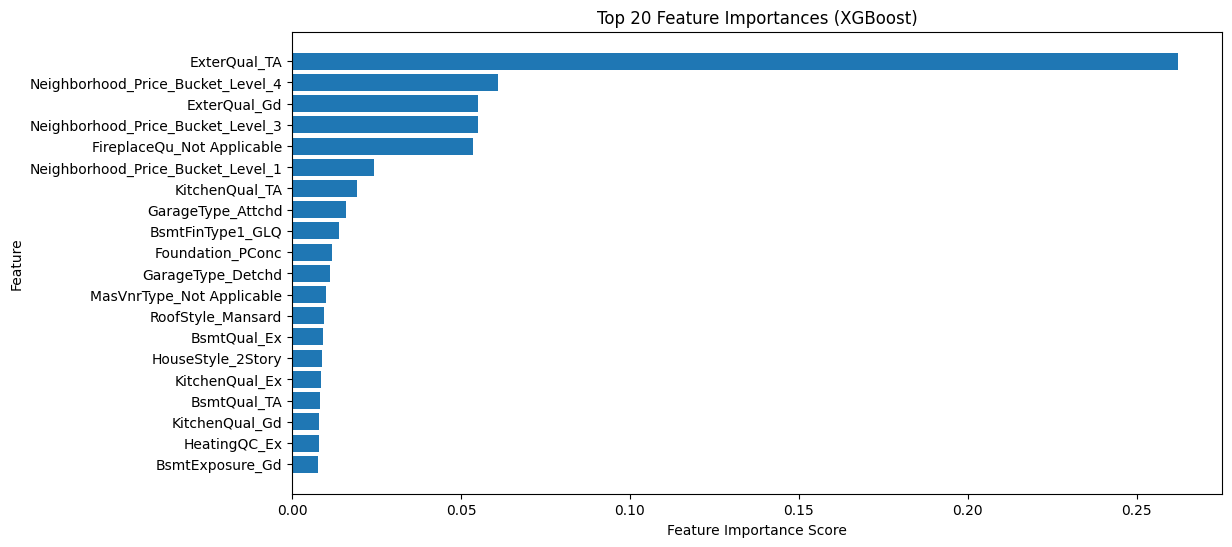

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# Define features and target
columns_to_include = df_encoded.columns.difference(['SalePrice'])
X = df_encoded[columns_to_include]
y = df_encoded['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and XGBoost Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', 
                                    random_state=42, n_jobs=-1))
])

# RandomizedSearch with fewer parameter combinations
param_dist = {
    'classifier__max_depth': randint(4, 12),  
    'classifier__learning_rate': uniform(0.01, 0.1),  
    'classifier__n_estimators': randint(50, 200),  
    'classifier__subsample': uniform(0.7, 0.3),  
    'classifier__colsample_bytree': uniform(0.7, 0.3),  
    'classifier__reg_lambda': uniform(0.1, 10),  
    'classifier__reg_alpha': uniform(0, 1)
}

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=25, cv=3, scoring='r2', n_jobs=-1, verbose=1, random_state=42
)  

# Fit with early stopping
random_search.fit(X_train, y_train)

# Best model evaluation on test set
best_model = random_search.best_estimator_
test_r2 = best_model.score(X_test, y_test)
print(f'Test R^2 Score: {test_r2:.4f}')

# Feature importance extraction
xgb_model = best_model.named_steps['classifier']
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [columns_to_include[j] for j in indices]

# Select **Top 20** most important features
top_n = 20
top_features = names[:top_n]
top_importances = importances[indices][:top_n]

# Plot top 20 feature importances
plt.figure(figsize=(12, 6))
plt.barh(names[:20], importances[indices][:20])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


In [15]:
print(top_features)

['ExterQual_TA', 'Neighborhood_Price_Bucket_Level_4', 'ExterQual_Gd', 'Neighborhood_Price_Bucket_Level_3', 'FireplaceQu_Not Applicable', 'Neighborhood_Price_Bucket_Level_1', 'KitchenQual_TA', 'GarageType_Attchd', 'BsmtFinType1_GLQ', 'Foundation_PConc', 'GarageType_Detchd', 'MasVnrType_Not Applicable', 'RoofStyle_Mansard', 'BsmtQual_Ex', 'HouseStyle_2Story', 'KitchenQual_Ex', 'BsmtQual_TA', 'KitchenQual_Gd', 'HeatingQC_Ex', 'BsmtExposure_Gd']


## Notes on Feature Engineering

In trying to determine was features that were the most relevant, I applied to models CART and XGBoost.

In addition to using two models, I also executed the models on all the features and a split between continuous and categorical features, to determine if there is a benefit to running them seperately.

Based on the results in terms of the R<sup>2</sup> score was:

1. XG Boost - All Variables 0.8932
2. XG Boost - Continuous Variables 0.8701
3. XG Boost - Categorical Data 0.7763